In [54]:
# ch12 01.ipynb

### 가상환경

In [55]:
# conda create -n [이름] python=[버전]
# conda activate [이름]

# conda deactivate
# conda remove-n [이름] --all

# tensorflow 안전지원 파이썬 버젼 3.11 로 가상환경 생성

### 딥러닝 감성분석
- 입력 ~ 1D Convolution + poling 반복 단계 과정정리

In [56]:
# 딥러닝 감성분석 - 딥러닝에 넣을 데이터 변환 과정 => 정수배열

# 입력 -> 토큰화 및 시퀀스 변화 -> 패딩(고정길이화) -> 임베딩(단어->벡터화)
# -> 1D Convolution + poling 반복 -> Flatten ->  Dense(은닉) -> 출력(softmax, 이진분류)
# -> 학습(Adam + binary_CrossEntropy) -> 검증 / 테스트 평가 -> 시각화 

# 시퀀스 단계에서 문장별로 숫자로 변환한 숫자 리스트의 길이를 맞추는 단계, 패딩
# 임베딩 단계에서 단어별의 관계와 의미를 수치로 표시한다. 벡터화

- 말뭉치 로딩(nltk) 데이터 로딩
- 토큰화(빈고 기반 인덱싱) 텍스트를 숫자로 변환
- 시퀀스 패딩 고정길이 배치 구성
- 임베딩 단어를 dense vector 표현학습
- 임베딩 발전
    - 한계 : 작은 데이터에서는 일반화 부족
    - 발전 : 사전학습(Word2vec) , 문맥적 임베딩(Bert, GPT)

In [57]:
#%pip install tensorflow

In [58]:
#%pip install numpy

In [59]:
# 토큰화
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# sample data
texts = [
    'I really love this movie',
    'I hate this boring film',
    'love love great film'
] # texts에 딕셔너리 형태도 들어가던데 그건 뭔지 ^

# 토큰화 객체(최대 단어 10, oov 토큰 지정)
tokenizer = Tokenizer(num_words=10, oov_token='UNK') # ^
# num_words
# 상위 10개의 단어만 사전에 포함한다.

# oov_token
# 모델이 학습할 때 보지 못한 단어를
# 하나의 특별한 토큰으로 치환할때 무엇으로 치환할지 설정

# num_words에 지정된 10의 값은 ovv_token까지 합해서 10개의 단어 사전을 생성한다.
# 그래서 단어인덱스에서 조회한
# 11번째 마지막 항목 'great': 10 은 실제로 단어사전에 해당되지않는다.

tokenizer.fit_on_texts(texts)
print(f'단어 인덱스 : {tokenizer.word_index}')

# 시퀀스로 변환 ^
seqs = tokenizer.texts_to_sequences(texts)
print(f'원본 시퀀스 : {seqs}')

# 패딩(최대길이를 6)
padded = pad_sequences(seqs,maxlen=6,padding='post') # ^
# padding='post'
# padding=pre'
print(f'패딩결과 : {padded}, 사이즈 : {padded.shape}')

단어 인덱스 : {'UNK': 1, 'love': 2, 'i': 3, 'this': 4, 'film': 5, 'really': 6, 'movie': 7, 'hate': 8, 'boring': 9, 'great': 10}
원본 시퀀스 : [[3, 6, 2, 4, 7], [3, 8, 4, 9, 5], [2, 2, 1, 5]]
패딩결과 : [[3 6 2 4 7 0]
 [3 8 4 9 5 0]
 [2 2 1 5 0 0]], 사이즈 : (3, 6)


In [60]:
# 임베딩 : 임베딩 레이어
import tensorflow as tf
# 패딩된 시퀀스 padded
vocab_size = 11 # unk 포함 단어인덱스 최대값 + 1
embed_dim = 4 # 작은 차원
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size,output_dim=embed_dim,input_length=6)
]) # ^
embeddings = model.predict(padded)
print(f'임베딩 텐서 모양 : {embeddings.shape}') # (3, 6, 4)
print(f'첫 문장 첫 단어 벡터 : {embeddings[0,0,:]}')

# output_dim = 4
# 단어 하나가 [0.12, -0.53, 0.88, 0.03]처럼 4개의 실수로 표현

# output_dim 출력 차원수는 4차원으로 적절히 설정

# 임베딩된 단어 벡터를 시각화 ^
# 단어 간 의미적 유사도 분포 확인

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
임베딩 텐서 모양 : (3, 6, 4)
첫 문장 첫 단어 벡터 : [-0.01885445  0.03581128 -0.02627629  0.01907071]


In [61]:
# 1D Convolution
# 1D Convolution은 "문장 속 특징을 찾는 탐지기",
# Pooling은 "중요한 것만 남기는 압축기",
# 반복하면
# "단어 조합 → 문장 전체 특징"까지 점점 높은 수준의 감정 특징을 뽑을 수 있다.

import numpy as np
import tensorflow as tf
# 임의 시퀀스(배치=1, 길이=6, 임베딩=4)
x= np.random.randn(1,6,4).astype('float32')
conv = tf.keras.layers.Conv1D(
    filters = 2 # 2개의 패턴을 감지
    ,kernel_size = 3 # 3-gram
    ,activation = 'relu' # 활성화 함수 설정
)
# tf.keras.layers.Conv1D(2, 3, activation='relu')
y = conv(x)
print(f'입력 : {x.shape}')
print(f'출력 : {y.shape}')
print(f'출력값 : {y.numpy()}')

# 입력 : (1, 6, 4)
# 출력 : (1, 4, 2)
# kernel_size = 3 으로 6개의 값을 3개씩 차례로 겨치게 묶어서 출력[1]은 4개
# filters = 2로 지정 했으므로 출력[2]은 2개

# 근데 여기서 다른 걸로 사용해서 패턴을 구할수는 없는건지 ^

입력 : (1, 6, 4)
출력 : (1, 4, 2)
출력값 : [[[0.38316175 0.        ]
  [0.6023103  0.        ]
  [2.089369   0.        ]
  [0.         0.        ]]]


In [62]:
# MaxPooling
pool = tf.keras.layers.MaxPooling2D

###

In [63]:
from tensorflow.keras.preprocessing.text import Tokenizer # 단어를 단어사전, 단어를 숫자로 변경
from tensorflow.keras.preprocessing.sequence import pad_sequences # 길이 맞추기
import numpy as np
import tensorflow as tf

texts = [
    'I really love this movie', # 긍정
    'I hate this boring film', # 부정
    'great love film', # 긍정
    'boring hate film' # 부정
]

labels = np.array([0,1,0,1]) # 긍정 : 0 , 부정 : 1

# 토큰화
tokenizer = Tokenizer(num_words=10,oov_token='UNK')
tokenizer.fit_on_texts(texts) # 단어 사전 생성
# 시퀀스화
seqs = tokenizer.texts_to_sequences(texts)
    # 단어사전을 기반으로 단어들을 숫자로 변경()
# 길이 맞추기
x = pad_sequences(seqs,maxlen=6,truncating='post')

# 임베딩 ##
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim = 11, output_dim = 8, input_length = 6),
    tf.keras.layers.Conv1D(16,3,activation='relu'), # ^
    # tf.keras.layers.Conv1D(filters, kernel_size, activation=...)
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(8,activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    # 마지막 출력 설정값에 어울리는 활성화함수를 선정 ^ :
        # 1개 : sigmoid
        # 2개 : softmax
    # ^
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc']) # ^
# binary_crossentropy
# binary_crossentropy는 정답이 0 또는 1인 이진분류에서 사용되는 손실함수
# 모델이 예측한 확률이 정답(0 or 1)과 얼마나 차이나는지를 계산해 손실값으로 나타낸다.
# 예측이 정답에 가까울수록 손실값은 작아지고,
# 멀수록 커져서 모델이 더 정확해지도록 학습을 유도한다.
# -> 옵티마이저는 손실값이 최소화, 작아지는 쪽으로 가중치를 조절한다.

history = model.fit(x,labels,epochs=15)

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - acc: 0.7500 - loss: 0.6918
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - acc: 0.7500 - loss: 0.6907
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - acc: 1.0000 - loss: 0.6902
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - acc: 1.0000 - loss: 0.6897
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - acc: 1.0000 - loss: 0.6890
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - acc: 1.0000 - loss: 0.6883
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - acc: 1.0000 - loss: 0.6876
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - acc: 1.0000 - loss: 0.6870
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - acc: 1.0000 - loss: 0.6863
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - acc: 1.0000 - loss: 0.6856
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - acc: 1.0000 - loss: 0.6849
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - acc: 1.0000 - loss: 0.6842
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - acc: 1.0000

In [64]:
preds = model.predict(x)
print(f"최종훈련 정확도 : {history.history['acc'][-1]}")
print(f'{preds}')
print(f'라벨 : {labels}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
최종훈련 정확도 : 1.0
[[0.49377638]
 [0.507323  ]
 [0.49452046]
 [0.504773  ]]
라벨 : [0 1 0 1]


###

In [65]:
#%pip install nltk

In [66]:
#%pip install scikit-learn

In [67]:
#%pip install matplotlib

In [68]:
# nltk 데이터로드
import nltk
nltk.download('mocie_reviews')
from nltk.corpus import movie_reviews

[nltk_data] Error loading mocie_reviews: Package 'mocie_reviews' not
[nltk_data]     found in index


In [69]:
# 재현성 시드 고정
# 재현성을 위해 랜덤 시드를 고정한다.
# 넘파이, 텐서플로우, 파이썬 기본 random 모듈의 시드를 모두 42로 설정
import random
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [70]:
# 데이터 로딩
ids = movie_reviews.fileids() # ^
# .fileids()
# NLTK 코퍼스(corpus) 안에 포함된 파일들의
# ID(이름 목록) 을 가져오는 메서드입니다.

# ID를 순환문으로 돌려, 전체 데이터의 행과, 카테고리를 추출
reviews = [movie_reviews.raw(id) for id in ids]
categories = [movie_reviews.categories(id)[0] for id in ids] # ^

In [71]:
# 하이퍼 파라미터
max_words = 10000 # 최대 단어수
    # 이전버젼에선 max_words가 num_words
maxlen = 500 # 문서길이
embed_dim = 64 # 임베딩 차원
batch_size = 256 # batch_size
epochs = 15 # epochs

# 토큰화 + 시퀀스 변화 + 패딩
tokenizer = Tokenizer(num_words = max_words, oov_token='UNK')
tokenizer.fit_on_texts(reviews)
seqs = tokenizer.texts_to_sequences(reviews)
x = pad_sequences(seqs,maxlen=maxlen,truncating='post') # ^
    # truncating : 자른다.
        # 기본값은 앞을 자른다. 'pre'
    # padding : 채운다.
        # 기본값은 앞을 채운다. 'pre'

# 체이닝 기법으로
# tokenizer.fit_on_texts(reviews).texts_to_sequences(reviews) 이런식으로
# 하려고했지만 이럴려면 그값으로 바로 반환하는 기능이있어야 한다. ^

# 라벨인코딩
label_map = {'pos':0,'neg':1}
y = np.array([label_map.get(c) for c in categories])

# train / test 분할
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y, stratify=y, random_state=42, test_size=0.2)

# 모델구성
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_words+1,output_dim=embed_dim,input_length=maxlen),
    tf.keras.layers.Conv1D(128,3,activation='relu'), # ^ 3인 이유 ^
    tf.keras.layers.MaxPool1D(), # ^
    tf.keras.layers.Conv1D(256,3,activation='relu'),
    # tf.keras.layers.GlobalAveragePooling1D() # ^
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64,activation='relu'), # ^ 이 단계가 있는 이유 ^
    tf.keras.layers.Dense(1,activation='sigmoid') # ^ sigmoid와 softmax ^
])

# 1)
# 두가지의 풀링툴의 차이 : MaxPool1D 와 GlobalAveragePooling1D
# MaxPool1D: 여러 값 중 가장 큰 값만 뽑아서 중요한 특징만 남긴다.
# GlobalAveragePooling1D: 전체 값을 평균내서 전체적인 흐름이나 대표값을 만든다.
    # 이 경우에는 Flatten이 필요없다.
    
# 차이점:
# MaxPool1D는 강한 특징 강조
# GlobalAveragePooling1D는 전체적인 정보 요약에 쓰인다.

# 2)
# tf.keras.layers.Dense(64,activation='relu'), 이 단계가 있는 이유

# 3)
# 출력층에서의 활성화 함수 선택, sigmoid와 softmax

####
# 컴파일 compile
adam = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])

# 콜백 callbacks (선택)
import tensorflow as tf
es = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)

# 학습 fit
history = model.fit(
    x_train,y_train,epochs=epochs,batch_size=batch_size,validation_split=0.2
    #, callbacks=[es]
    ) # ^

# validatioin_split

# callbacks

Epoch 1/15


c:\Users\Playdata2\miniconda3\envs\conda_venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 384ms/step - acc: 0.5336 - loss: 0.6982 - val_acc: 0.5437 - val_loss: 0.6901
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 351ms/step - acc: 0.4891 - loss: 0.6949 - val_acc: 0.5437 - val_loss: 0.6925
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 352ms/step - acc: 0.5188 - loss: 0.6923 - val_acc: 0.5188 - val_loss: 0.6926
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 345ms/step - acc: 0.5414 - loss: 0.6909 - val_acc: 0.5562 - val_loss: 0.6903
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 365ms/step - acc: 0.6187 - loss: 0.6893 - val_acc: 0.5188 - val_loss: 0.6900
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 346ms/step - acc: 0.5391 - loss: 0.6868 - val_acc: 0.5188 - val_loss: 0.6919
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 358ms/step - acc: 0.5523 - loss: 0.6811 - val_acc: 0.5250 - val_loss: 0.6906
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 352ms/step - acc: 0.5891 - loss: 0.6714 - val_acc: 0.5281 - val_loss: 0.6892
Epoch 9/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 355ms/step - acc: 0.6570 - loss: 0.6488 - va

#### 2) tf.keras.layers.Dense(64,activation='relu'), 이 단계가 있는 이유

#### 3) 출력층 활성화함수 : 시그모이드와 소프트맥스
| 항목       | 시그모이드 | 소프트맥스        |
| -------- | ----- | ------------ |
| 출력 범위    | 0~1   | 0~1 (합=1)    |
| 사용 목적    | 이진 분류 | 다중 클래스 분류    |
| 확률 해석    | 개별 확률 | 전체 클래스 확률 분포 |
| 출력층 노드 수 | 1개    | 클래스 수와 동일    |

- 시그모이드: "이게 1일 확률은 얼마일까?"
- 소프트맥스: "이 중에서 어느 클래스가 가장 가능성이 높을까?"

In [72]:
# conv1d 배치크기, 시퀀스길이, 채널수
# 배치크기=32, 시퀀스길이=10, 채널수=64
x = tf.random.normal(shape=(32,10,64))

# Flatten
print(tf.keras.layers.Flatten()(x).shape)

# GlobalAveragePooling1D
tf.keras.layers.GlobalAveragePooling1D()(x).shape
    # 각 채널 Feature map 마다 평균

(32, 640)


TensorShape([32, 64])

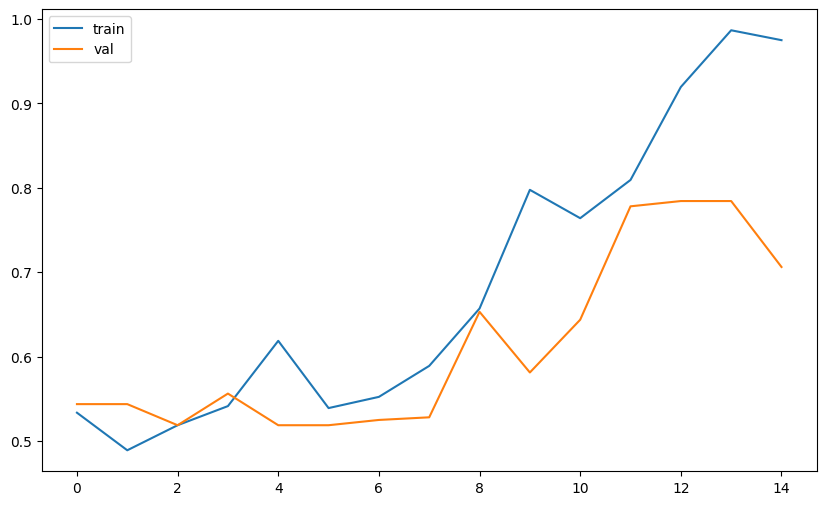

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - acc: 0.6425 - loss: 0.8272
test loss : 0.8271718621253967, test acc : 0.6424999833106995


In [73]:

# 학습결과 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(history.history['acc'],label='train')
plt.plot(history.history['val_acc'],label='val')
plt.legend()
plt.show()

# 테스트 평가
test_loss, test_acc = model.evaluate(x_test,y_test)
print(f'test loss : {test_loss}, test acc : {test_acc}')

In [74]:
# 임의의 데이터로 예측
sample_texts = [
    "This movie was absolutely fantastic and inspiring", # 긍정
    "I really disliked the plot and the acting was terrible" # 부정
]

# 모델에 들어간 x_train의 형태로 만들기
# 만들어진 단어사전으로 시퀀스 변환
seqs = tokenizer.texts_to_sequences(sample_texts)
# 패딩으로 길이 맞추기
x_sample = pad_sequences(seqs,maxlen=maxlen,truncating='post')
y_pred = model.predict(x_sample)
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


array([[0.94982964],
       [0.9657033 ]], dtype=float32)

In [75]:
# 토크나이저하고, 모델하고 같이 제공해야한다.
# 그래야 모델을 적용하기위한 데이터 형식을 변환하고, 모델을 만들 수 있기 때문이다.

### 위에 나온 기존 모델의 성능 올리기 방안
```
5 가지 개선 아이디어
    1) GlobalMaxPooling 사용(Flatten 대신) → 파라미터 감소
    2) 다중 커널 크기(3,5,7) 병렬 적용 (TextCNN 구조)
    3) Pretrained Embeddings (GloVe) 로 초기화
    4) 과적합 방지: Dropout, L2 Regularization
    5) 학습률 스케줄링(Cosine annealing, ReduceLROnPlateau)
```

#### 개선 1 : GlobalMaxPooling 사용 → 파라미터 감소
- Flatten 대신 GlobalMaxPooling 각 필터의 최대값만 추출해서 파라미터수를 감소

- 토크나이저 - 시퀀스 - 패딩 --> X , 라벨링 -> y
- 분할
- 모델... Flatten GlobalMaxPool1D

In [76]:
# nltk 데이터로드
import nltk
nltk.download('mocie_reviews')
from nltk.corpus import movie_reviews

# 재현성 시드 고정
import random
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# 데이터 로딩
ids = movie_reviews.fileids() # ^

# ID를 순환문으로 돌려, 전체 데이터의 행과, 카테고리를 추출
reviews = [movie_reviews.raw(id) for id in ids]
categories = [movie_reviews.categories(id)[0] for id in ids]

# 하이퍼 파라미터
max_words = 10000 # 최대 단어수
    # 이전버젼에선 max_words가 num_words
maxlen = 500 # 문서길이
embed_dim = 64 # 임베딩 차원
batch_size = 256 # batch_size
epochs = 14 # epochs

# 토큰화 + 시퀀스 변화 + 패딩
tokenizer = Tokenizer(num_words = max_words, oov_token='UNK')
tokenizer.fit_on_texts(reviews)
seqs = tokenizer.texts_to_sequences(reviews)
x = pad_sequences(seqs,maxlen=maxlen,truncating='post')

# 라벨인코딩
label_map = {'pos':0,'neg':1}
y = np.array([label_map.get(c) for c in categories])

# train / test 분할
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y, stratify=y, random_state=SEED, test_size=0.2)

# 모델구성
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_words+1,output_dim=embed_dim,input_length=maxlen),
    tf.keras.layers.Conv1D(128,3,activation='relu'),
    tf.keras.layers.Conv1D(256,3,activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

# 컴파일 compile
adam = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])

# 콜백 callbacks (선택)
import tensorflow as tf
es = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)

# 학습 fit
history = model.fit(
    x_train,y_train,epochs=epochs,batch_size=batch_size,validation_split=0.2
    #, callbacks=[es]
    )

# 임의의 데이터로 예측
sample_texts = [
    "This movie was absolutely fantastic and inspiring", # 긍정
    "I really disliked the plot and the acting was terrible" # 부정
]

# 만들어진 단어사전으로 시퀀스 변환
seqs = tokenizer.texts_to_sequences(sample_texts)
# 패딩으로 길이 맞추기
x_sample = pad_sequences(seqs,maxlen=maxlen,truncating='post')
y_pred = model.predict(x_sample)
y_pred

[nltk_data] Error loading mocie_reviews: Package 'mocie_reviews' not
[nltk_data]     found in index


Epoch 1/14


c:\Users\Playdata2\miniconda3\envs\conda_venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 512ms/step - acc: 0.5117 - loss: 0.6936 - val_acc: 0.4563 - val_loss: 0.6962
Epoch 2/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 466ms/step - acc: 0.5109 - loss: 0.6924 - val_acc: 0.4563 - val_loss: 0.6959
Epoch 3/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 472ms/step - acc: 0.5117 - loss: 0.6914 - val_acc: 0.4500 - val_loss: 0.6953
Epoch 4/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 477ms/step - acc: 0.5242 - loss: 0.6892 - val_acc: 0.4875 - val_loss: 0.6944
Epoch 5/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 499ms/step - acc: 0.5359 - loss: 0.6833 - val_acc: 0.5188 - val_loss: 0.6896
Epoch 6/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 485ms/step - acc: 0.5484 - loss: 0.6694 - val_acc: 0.5375 - val_loss: 0.6757
Epoch 7/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 478ms/step - acc: 0.5922 - loss: 0.6405 - val_acc: 0.6031 - val_loss: 0.6491
Epoch 8/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 509ms/step - acc: 0.7164 - loss: 0.5776 - val_acc: 0.7281 - val_loss: 0.5980
Epoch 9/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 488ms/step - acc: 0.8344 - loss: 0.4724 - va

array([[0.90658116],
       [0.9188799 ]], dtype=float32)

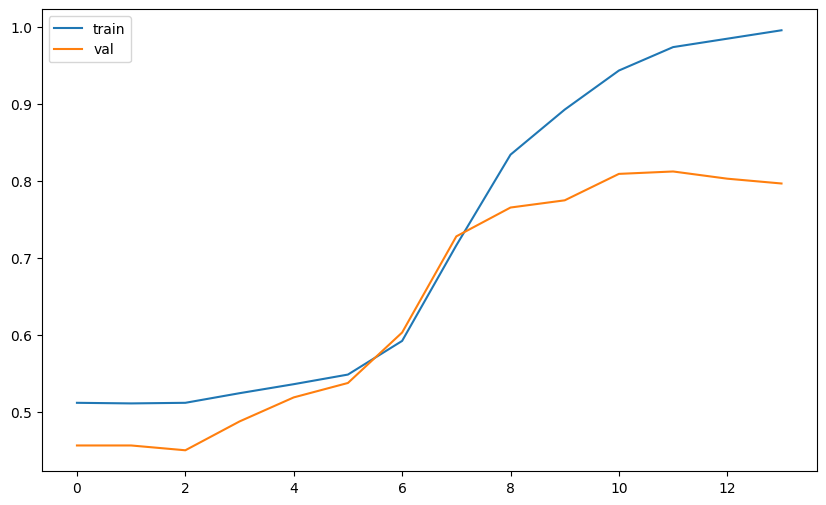

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - acc: 0.7525 - loss: 0.6944
test loss : 0.6943673491477966, test acc : 0.7524999976158142


In [77]:

# 학습결과 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(history.history['acc'],label='train')
plt.plot(history.history['val_acc'],label='val')
plt.legend()
plt.show()

# 테스트 평가
test_loss, test_acc = model.evaluate(x_test,y_test)
print(f'test loss : {test_loss}, test acc : {test_acc}')

#### 개선 2 : 다중 커널 크기 병렬 적용(TextCNN)
- 커널크기 3 5 7 동시에 사용 다양한 n-gram 포착
- tri-gram, 5-gram, 7-gram

Epoch 1/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 583ms/step - acc: 0.5109 - loss: 0.6977 - val_acc: 0.4563 - val_loss: 0.6967
Epoch 2/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 517ms/step - acc: 0.7430 - loss: 0.6758 - val_acc: 0.5437 - val_loss: 0.6888
Epoch 3/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 576ms/step - acc: 0.9195 - loss: 0.6650 - val_acc: 0.4563 - val_loss: 0.6922
Epoch 4/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 543ms/step - acc: 0.7523 - loss: 0.6497 - val_acc: 0.4563 - val_loss: 0.6927
Epoch 5/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 533ms/step - acc: 0.9961 - loss: 0.6309 - val_acc: 0.5938 - val_loss: 0.6868
Epoch 6/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 527ms/step - acc: 1.0000 - loss: 0.6081 - val_acc: 0.7000 - val_loss: 0.6821
Epoch 7/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 524ms/step - acc: 1.0000 - loss: 0.5784 - val_acc: 0.6938 - val_loss: 0.6766
Epoch 8/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 543ms/step - acc: 1.0000 - loss: 0.5393 - val_acc: 0.7563 - val_loss: 0.6658
Epoch 9/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 530ms/step - acc: 1.0000 - loss: 

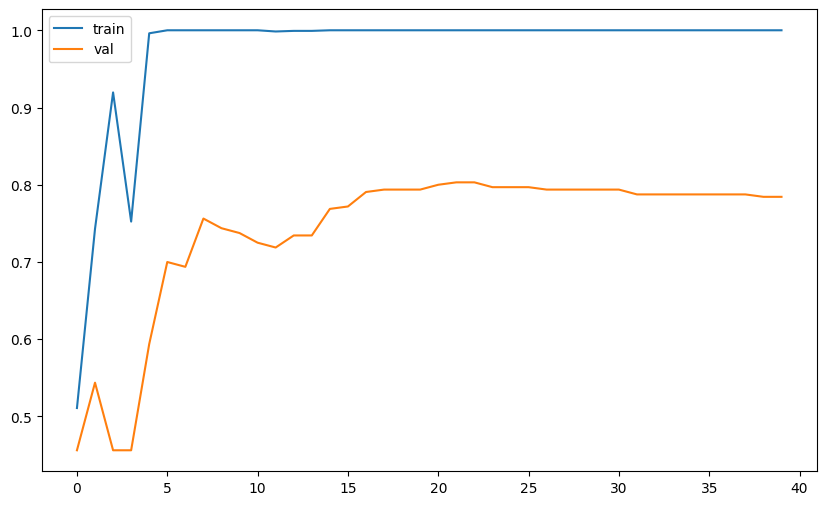

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.7475 - loss: 0.5054
test loss : 0.5053504705429077  test acc : 0.7475000023841858
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


array([[0.39128292],
       [0.61038685]], dtype=float32)

In [78]:
####
# 레이어를 생성하고 수시로 적용?
from tensorflow.keras.layers import Input, Concatenate

# 입력 레이어
input_layer = Input(shape=(maxlen ,), dtype='int32')

# 임베딩 레이어
embedding = tf.keras.layers.Embedding(max_words+1,embed_dim,input_length=maxlen)(input_layer)
conv_blocks = []
for kernel_size in [3,5,7]:
    conv = tf.keras.layers.Conv1D(128,kernel_size,activation='relu')(embedding)
    pool = tf.keras.layers.GlobalMaxPooling1D()(conv)
    conv_blocks.append(pool)
    
# 병렬 브랜치 결합 ^
concat = Concatenate()(conv_blocks)

# 완전연결층
dense = tf.keras.layers.Dense(64,activation='relu')(concat)
output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)
# 출력을 하나 했을때 softmax를 사용하면, 합이 1이여야되기때문에 1만 나온다.

# 모델 생성
model = tf.keras.models.Model(inputs = input_layer, outputs =output )
####

# 컴파일
adam =  tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=adam, loss='binary_crossentropy',metrics=['acc'])
# 콜백(선택)
import tensorflow as  tf
es = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
# 학습
history = model.fit(
    x_train,y_train,epochs=40,batch_size=batch_size,validation_split = 0.2
    # ,callbacks=[es]
)

# 학습결과 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(history.history['acc'],label='train')
plt.plot(history.history['val_acc'], label='val')
plt.legend()
plt.show()
# 테스트 평가
test_loss,  test_acc =  model.evaluate(x_test,y_test)
print(f'test loss : {test_loss}  test acc : {test_acc}')

# 임의의 데이터로 예측
sample_texts = [
    "This movie was absolutely fantastic and inspiring",
    "I really disliked the plot and the acting was terrible"
]
x_sample = tokenizer.texts_to_sequences(sample_texts)
x_sample = pad_sequences(x_sample,maxlen=maxlen,truncating='post')
x_sample_predict = model.predict(x_sample)
x_sample_predict

In [79]:
# test 데이터로 성능 조회해보기?

#### 개선 3 :Pretrained Embeddings (GloVe) 로 초기화

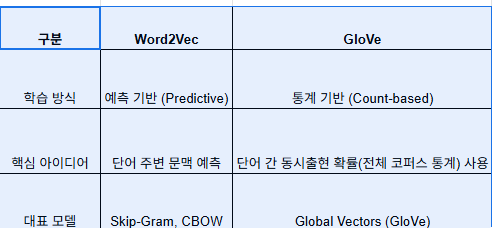

In [80]:
#%pip install gensim

In [81]:
import gensim.downloader as api
import numpy as np
# Glove 모델 (50차원)
wv = api.load('glove-wiki-gigaword-50')

In [82]:
# 데이터 셋 사용된 단어들을
# Glove가 이미 학습한 벡터로 연결해서
# Embedding Laye 의 가중치 초기값을 사용하기 위해 embedding_matrix를 만드는 것
wv['king'].shape

# 저장된 모델의 들어가야할 데이터는 50차원 짜리

(50,)

매칭 : 9722 비매칭 : -277
커버리지 : 1.0293276866066703
Epoch 1/15


c:\Users\Playdata2\miniconda3\envs\conda_venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 377ms/step - acc: 0.4852 - loss: 0.8185 - val_acc: 0.4563 - val_loss: 0.7747
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 334ms/step - acc: 0.5719 - loss: 0.6855 - val_acc: 0.5437 - val_loss: 0.6905
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 342ms/step - acc: 0.5328 - loss: 0.6861 - val_acc: 0.4563 - val_loss: 0.7124
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 342ms/step - acc: 0.5945 - loss: 0.6592 - val_acc: 0.5656 - val_loss: 0.6811
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 347ms/step - acc: 0.6867 - loss: 0.6497 - val_acc: 0.5813 - val_loss: 0.6840
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 346ms/step - acc: 0.6922 - loss: 0.6345 - val_acc: 0.6219 - val_loss: 0.6787
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 337ms/step - acc: 0.9531 - loss: 0.6169 - val_acc: 0.6000 - val_loss: 0.6743
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 331ms/step - acc: 0.9086 - loss: 0.6020 - val_acc: 0.6313 - val_loss: 0.6685
Epoch 9/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 341ms/step - acc: 0.9563 - loss: 0.5814 - va

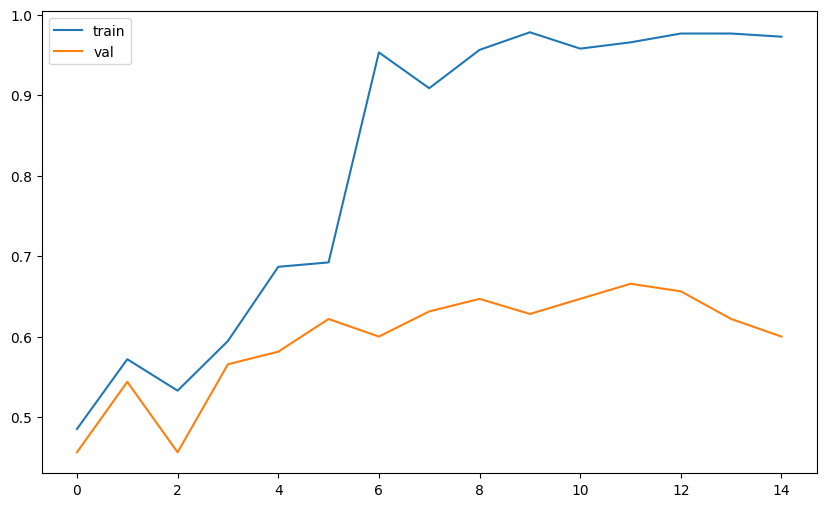

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.6100 - loss: 0.6335
test loss : 0.6335094571113586, test acc : 0.6100000143051147
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


array([[0.5895875],
       [0.6504072]], dtype=float32)

In [83]:
from tensorflow.keras.preprocessing.text import Tokenizer # 단어를 단어사전, 단어를 숫자로 변경
from tensorflow.keras.preprocessing.sequence import pad_sequences # 길이 맞추기
import numpy as np
import tensorflow as tf

# 하이퍼 파라미터
max_words = 10000 # 최대 단어수
    # 이전버젼에선 max_words가 num_words
maxlen = 500 # 문서길이
embed_dim = 50 # 임베딩 차원
batch_size = 256 # batch_size
epochs = 15 # epochs

# 토큰화 + 시퀀스 변화 + 패딩
tokenizer = Tokenizer(num_words = max_words, oov_token='UNK')
tokenizer.fit_on_texts(reviews)
seqs = tokenizer.texts_to_sequences(reviews)
x = pad_sequences(seqs,maxlen=maxlen,truncating='post')

# 라벨인코딩
label_map = {'pos':0,'neg':1}
y = np.array([label_map.get(c) for c in categories])

# train / test 분할
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y, stratify=y, random_state=42, test_size=0.2)


###

# 임베딩 매트릭스 초기화
word_index = tokenizer.word_index
num_words = min(max_words,  len(word_index)+1)
embedding_matrix = np.random.normal( # ^ normal
    loc = 0.0, scale=0.1, size = (num_words, embed_dim)
)

# glove 매칭
hits = 0
misses = 0
for word, i in word_index.items():
    if i >= max_words:
        continue
    try :
        embedding_vector = wv[word] # GloVe에서 단어 벡터 찾기
        embedding_matrix[i] = embedding_vector # 해당위치에 저장
        hits += 1
    except KeyError:
        misses += -1
print(f'매칭 : {hits} 비매칭 : {misses}')
print(f'커버리지 : {hits / (hits+misses)}')

###

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(num_words,output_dim=embed_dim,input_length=maxlen,
                              weights=[embedding_matrix]),
    tf.keras.layers.Conv1D(128,3,activation='relu'),
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.Conv1D(256,3,activation='relu'),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid') # sigmoid - binary_crossentropy
])

# compile
adam = tf.keras.optimizers.Adam(learning_rate = 1e-3)
model. compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])

# history
history = model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_split=0.2)

# plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(history.history['acc'],label='train')
plt.plot(history.history['val_acc'],label='val')
plt.legend()
plt.show()

# 테스트 평가
test_loss, test_acc = model.evaluate(x_test,y_test)
print(f'test loss : {test_loss}, test acc : {test_acc}')

# 임의의 데이터로 예측
sample_texts = [
    "This movie was absolutely fantastic and inspiring",
    "I really disliked the plot and the acting was terrible"
]
x_sample = tokenizer.texts_to_sequences(sample_texts)
x_sample = pad_sequences(x_sample,maxlen=maxlen,truncating='post')
x_sample_predict = model.predict(x_sample)
x_sample_predict

####

Epoch 1/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 537ms/step - acc: 0.4828 - loss: 1.0095 - val_acc: 0.4563 - val_loss: 0.9893
Epoch 2/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - acc: 0.5469 - loss: 0.9602 - val_acc: 0.4563 - val_loss: 0.9496
Epoch 3/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 467ms/step - acc: 0.6391 - loss: 0.9220 - val_acc: 0.4625 - val_loss: 0.9170
Epoch 4/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 490ms/step - acc: 0.6781 - loss: 0.8876 - val_acc: 0.4594 - val_loss: 0.8894
Epoch 5/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 503ms/step - acc: 0.7039 - loss: 0.8566 - val_acc: 0.4563 - val_loss: 0.8660
Epoch 6/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 480ms/step - acc: 0.7367 - loss: 0.8283 - val_acc: 0.4750 - val_loss: 0.8427
Epoch 7/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 480ms/step - acc: 0.8336 - loss: 0.8026 - val_acc: 0.6812 - val_loss: 0.8217
Epoch 8/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 474ms/step - acc: 0.8633 - loss: 0.7809 - val_acc: 0.6781 - val_loss: 0.8030
Epoch 9/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 477ms/step - acc: 0.8711 - loss: 

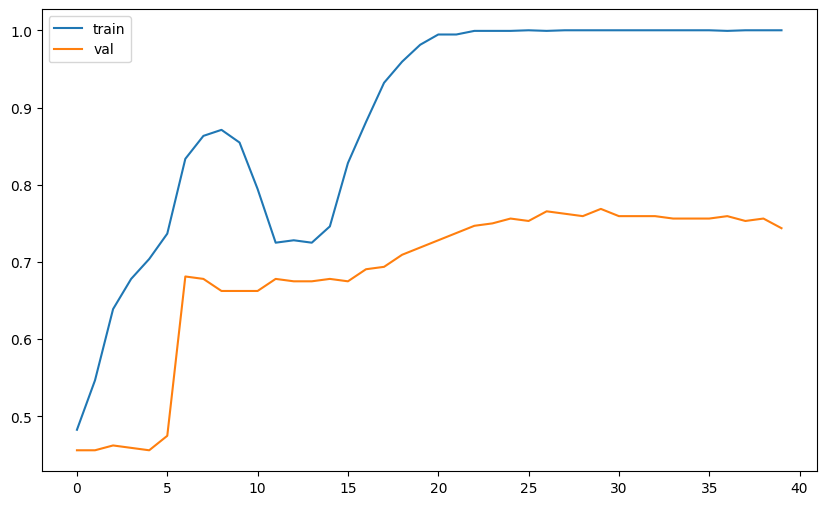

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.7325 - loss: 0.7139
test loss : 0.7138848304748535  test acc : 0.7325000166893005
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


array([[0.04684735],
       [0.09041563]], dtype=float32)

In [84]:
# kernel_regularizer=tf.keras.regularizers.l2(1e-3) ^

# 입력 레이어
input_layer = Input(shape=(maxlen ,), dtype='int32')

# 임베딩 레이어
embedding = tf.keras.layers.Embedding(max_words+1,embed_dim,input_length=maxlen)(input_layer)
conv_blocks = []
for kernel_size in [3,5,7]:
    conv = tf.keras.layers.Conv1D(128,
                                  kernel_size,
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(1e-3)
                                  )(embedding)
    pool = tf.keras.layers.GlobalMaxPooling1D()(conv)
    conv_blocks.append(pool)
    
# 병렬 브랜치 결합
concat = Concatenate()(conv_blocks)

# 완전연결층
dense = tf.keras.layers.Dense(128,activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l2(1e-3)
                              )(concat)
dense = tf.keras.layers.Dropout(0.5)(dense)
dense = tf.keras.layers.Dense(64,activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l2(1e-3)
                              )(concat)
dense = tf.keras.layers.Dropout(0.5)(dense)
output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

# 모델 생성
model = tf.keras.models.Model(inputs = input_layer, outputs =output )

# 컴파일
adam =  tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=adam, loss='binary_crossentropy',metrics=['acc'])
# 콜백(선택)
import tensorflow as  tf
es = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
# 학습
history = model.fit(
    x_train,y_train,epochs=40,batch_size=batch_size,validation_split = 0.2
    # ,callbacks=[es]
)

# 학습결과 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(history.history['acc'],label='train')
plt.plot(history.history['val_acc'], label='val')
plt.legend()
plt.show()
# 테스트 평가
test_loss,  test_acc =  model.evaluate(x_test,y_test)
print(f'test loss : {test_loss}  test acc : {test_acc}')

# 임의의 데이터로 예측
sample_texts = [
    "This movie was absolutely fantastic and inspiring",
    "I really disliked the plot and the acting was terrible"
]
x_sample = tokenizer.texts_to_sequences(sample_texts)
x_sample = pad_sequences(x_sample,maxlen=maxlen,truncating='post')
x_sample_predict = model.predict(x_sample)
x_sample_predict

In [85]:
# 임베딩 매트릭스를 초기화하고
# GloVe로 덮어쓰는 것 = ‘모든 단어가 벡터를 가지고
# (임베딩 매트릭스의 모든 행(단어 인덱스 위치)에 값이 채워져 있어야 한다),
# 가능한 단어는 이미 의미 있는 벡터를 쓰고, 없는 단어는 학습으로 채운다

In [86]:
# 초기화 = 모든 단어 인덱스에 벡터 값이 존재하도록 보장
# GloVe로 매칭되는 단어는 덮어쓰고, 매칭 안 되는 단어는 학습으로 채워짐
# 0으로 채우는 건 피하는 게 좋음 → 계산상 문제와 학습 효율 저하 가능